In [1]:
import numpy as np
import scipy as sc
import scipy.special as sp
import scipy.stats as ss
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import datetime
fontsize_axes = 18.0
fontsize_ticker = 16.0

# Profit and loss of blockchain miners

Let $\pi_{\text{BTC}}$ be the bitcoin price in USD and $\pi_{\text{BTC}}$ be the number of bitcoin as a bounty for finding a new block. The reward is worth

$$b = n_{\text{BTC}}\cdot\pi_{\text{BTC}}$$

In [2]:
r = requests.get('https://blockchain.info/ticker')
quote  = dict(r.json())
n_BTC, π_BTC = 6.25, quote["USD"]['last']
b = n_BTC * π_BTC
print('The BTC price is $' + str(π_BTC) )
print('The reward for finding a block amount to $' + str(b) )

The BTC price is $41681.49
The reward for finding a block amount to $260509.3125


The electricity consumption estimated by the Cambridge Bitcoin Electricity Consumption Index [CBECI](https://cbeci.org/) in TWh per year is converted into kWh par hour and denoted by $W$.

In [3]:
tW_data = pd.read_csv("../Data/BTC_electricity_consumption.csv")
tW_data
tW_data['Date'] = pd.to_datetime(tW_data['Date and Time'])
tW_df = tW_data[['Date','GUESS']].rename(columns={"GUESS": "tW"})
# Operational cost of the network
W =  tW_df.tW.values[-1] * 10**9 / 365.25 / 24

print('On '+ str(tW_df.Date.values[-1]))
print('The network consumes ' + str(tW_df.tW.values[-1]) + ' tWh per year')  
print('The network consumes ' + str(W) + ' kWh per hour')  

On 2021-09-13T00:00:00.000000000
The network consumes 95.67642893329122 tWh per year
The network consumes 10914491.094374996 kWh per hour


The time unit is the hour, The network finds 6 new blocks eevry hour. The number of blocks up to time $t$ is a Poisson process $(N_t)_{t\geq0}$ of intensity $\lambda = 6$.

In [4]:
# Intensity of the Poisson process
λ = 6
print('The time unit is the hour, the Poisson process intensity is λ = ' + str(λ))

The time unit is the hour, the Poisson process intensity is λ = 6


The wealth of a miner is given by  

$$
R_t = u-c\cdot t+b\cdot \tilde{N}_t,
$$

where 

- $u$ is the initial reserves
- $c$ is the operational cost of mining
- $b$ the block finding reward
- $\tilde{N}_t$ is a Poisson process of intensity $p\lambda$ the number of blocks found by the considered miner until $t\geq0$

$p\in(0,1/2)$ corresponds to the share of the network hash power owned by the miner. The operational cost is given by

$$
c = p\cdot W\cdot \pi_{\text{W}}, 
$$

where $\pi_{W}$ is the prices ff one kWh of électricité. The net profit condition reads as 

$$
b\cdot\lambda -  W\cdot \pi_{\text{W}}>0
$$

and does not depend on $p$.

In [5]:
print('The net profit condition holds if the cost of electricity is lower than '
      + str(np.around(λ * b / W, decimals = 3))+
      ' when following the protocol')

The net profit condition holds if the cost of electricity is lower than 0.143 when following the protocol


The ruin time is defined by

$$
\tau_u = \inf\{t\geq0\text{ ; }R_t\leq0\}.
$$

The ruin probability up to time horizon $t\geq0$ is defined as 

$$
\psi(u,t) = \mathbb{P}(\tau_u \leq t).
$$

The ultimate ruin probability

$$
\psi(u) = \mathbb{P}(\tau_u < \infty)
$$

The miner surplus if ruin does not occur is given by
$$
V(u,t) = \mathbb{E}(R_t\mathbb{I}_{\tau_u>t}).
$$

The ruin probability and expected surplus up to an exponential time horizon $T\sim \text{Exp}(t)$ are denoted by

$$
\widehat{\psi}(u,t) = \mathbb{E}[\psi(u,T)],\text{ et } \widehat{V}(u,t) = \mathbb{E}[V(u,T)].
$$

Let us compare $\psi(u,t)$ and $\widehat{\psi}(u,t)$, and $V(u,t)$ et $\widehat{V}(u,t)$. The parameters are set as follows

$$
t = 6h,\pi_W = 0.06,\text{ and } p = 0.1.
$$

In [6]:
# Function to compute the ruin probability up to time t
def ψ_t(u, t, b, c, p, λ):
    n = ma.floor((c * t - u) / b)
    return(sum([u / (u + b * k) * ss.poisson.pmf(k, p * λ * (u + b * k) / c) for k in range(n+1)]))

# Function to compute the ultimate ruin probability
def ψ(u, b, c, p, λ):
    def f(x): 
        return(c * x + p * λ * (np.exp(-b*x) - 1))
    theta_star = sc.optimize.root_scalar(f, bracket=[np.log(p * b * λ / c) / b, 100],
                                            method='brentq').root
    return(np.exp(-theta_star * u))

# Function to compute the revenue function over a finite time horizon using Prop 1
def V_t(u, t, b, c, p, λ, K):
    # K is a truncation order for the infinite serie     
    U = [min(1, (u + b * k) / c / t) for k in range(K)]
    V = [max(0, u + k * b - c * t) * (-1) ** k * ss.poisson.pmf(k, p * λ * t) for k in range(K)]
    G_k = [1]
    for k in range(1,K,1):
        G_k.append(
            -sum([
                sp.binom(k,i) * U[i]**(k-i)*G_k[i] 
                for i in range(0,k,1)]))
    return(np.dot(V,G_k))

# Function to compute the value function over an exponential time horizon
def V_T(u, t, b, c, p, λ):
    γ = p * λ * b - c
    def f(x): 
            return(c * t * x + (1 + p * λ * t) - p *λ * t * np.exp(x * b) )
    rho_star = sc.optimize.root_scalar(f, bracket=[np.log(c / p * b * λ) / b-10, 
                                                      np.log(c / p / b / λ) / b],
                                          method='brentq').root
    return(γ * t + u - γ * t * np.exp(rho_star * u))

# Function to compute the ruin probability over an exponential time horizon via
def ψ_T(u, t, b, c, p, λ):
    
    def f(x): 
            return(c * t * x + (1 + p * λ * t) - p *λ * t * np.exp(x * b) )
    rho_star = sc.optimize.root_scalar(f, bracket=[np.log(c / p * b * λ) / b-10, 
                                                      np.log(c / p / b / λ) / b],
                                          method='brentq').root
    return(np.exp(rho_star * u))

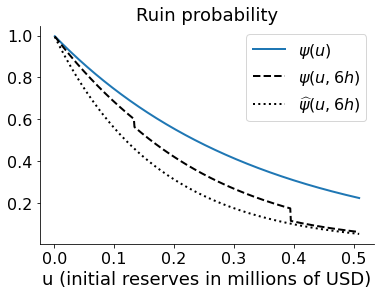

In [7]:
# Time horizon, price of the electricity and  hashpower
t, π_W, p = 6, 0.1, 0.1
# operational cost per hour
c = p * π_W * W
u_vec = np.arange(1000, 510000, 1000) # Sequence of initial reserves
ψ_u_t_vec = [ψ_t(u, t, b, c, p, λ) for u in u_vec]
ψ_u_t_vec
ψ_u_T_vec = [ψ_T(u, t, b, c, p, λ) for u in u_vec]
ψ_u_vec = [ψ(u, b, c, p, λ) for u in u_vec]
ψ_u_vec
plt.plot(u_vec *1e-6, ψ_u_vec, '-', label = '$\psi(u)$', linewidth=2)
plt.plot(u_vec *1e-6, ψ_u_t_vec, '--', label = '$\psi(u,6h)$', linewidth=2, color ='k')
plt.plot(u_vec*1e-6, ψ_u_T_vec, linestyle = 'dotted', label = '$\widehat{\psi}(u,6h)$', linewidth=2, color ='k')
plt.xlabel('u (initial reserves in millions of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize=fontsize_ticker)

sns.despine()

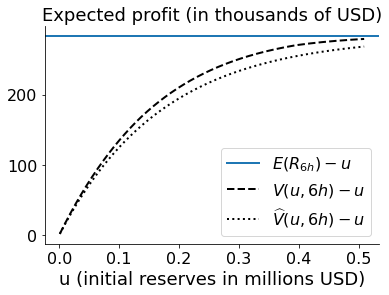

In [8]:
# Time horizon, price of the electricity and  hashpower
t, π_W, p = 6, 0.1, 0.1
c = p * π_W * W
u_vec = np.arange(1000, 510000, 1000) # Sequence of initial reserves
V_u_t_vec = np.array([V_t(u, t, b, c, p, λ, 40)-u for u in u_vec])/1000
V_u_T_vec = np.array([ V_T(u, t, b, c, p, λ)-u for u in u_vec])/1000
plt.axhline(y = (- c * t + p * λ * b * t)/1000, label = '$E(R_{6h})-u$', linewidth=2)
plt.plot(u_vec*1e-6, V_u_t_vec, '-', label = '$V(u,6h)-u$', linestyle = 'dashed', color = 'k', linewidth=2)
plt.plot(u_vec*1e-6, V_u_T_vec, linestyle = 'dotted', label = '$\widehat{V}(u,6h)-u$', color = 'k', linewidth=2)
plt.xlabel('u (initial reserves in millions USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in thousands of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize=fontsize_ticker)
sns.despine()

## Sensitivity analysis with respect to the model parameters

The ruin probability and expected profit are computed for various  $u,t,\pi_W$ et $p$. 

In [9]:
u_vec = np.arange(10000, 2050000, 50000)
t_vec = np.array([24, 7*24, 14*24])
π_W_vec = np.arange(0.05, 0.2, 0.01)
p_vec = np.arange(0.01, 0.21, 0.01)
ψ_V_df = pd.DataFrame({'u':[],'t':[],'π_W':[], 'p':[], 'ψ_u':[],'V_u_T':[], 'EG':[]})
for t in t_vec:
    for π_W in π_W_vec:
        for p in p_vec:
            c = p * π_W * W
            res = pd.DataFrame({'u':u_vec,
                        't':np.repeat(t, len(u_vec)), 
                        'π_W':np.repeat(π_W, len(u_vec)),
                        'p':np.repeat(p, len(u_vec)),
                        'ψ_u_T':[ψ_T(u, t, b, c, p, λ) for u in u_vec],
                        'ψ_u':[ψ(u, b, c, p, λ) for u in u_vec], 
                        'V_u_T':[ V_T(u, t, b, c, p, λ) for u in u_vec],
                       'EG': np.repeat(- c * t + p * λ * b * t, len(u_vec))})
            ψ_V_df = pd.concat([ψ_V_df, res])
# ψ_V_df

## Depending on $t$

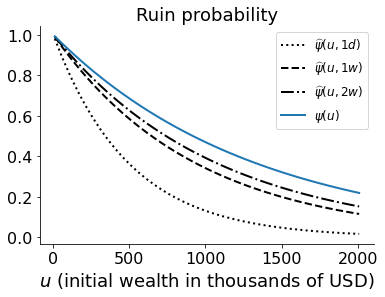

In [12]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
π_W = 0.13
p = 0.1
selector = (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
t_vec_ex = np.array([24, 24*7, 24*14]) 
time_horizon = np.array(['1d', '1w', '2w'])
for k in range(len(t_vec_ex)):
    c = p * π_W * W
#     plt.plot(u_vec, ψ_V_df.ψ_u[(selector) & (ψ_V_df.t == t_vec_ex[k])].values, color = 'k', alpha = 0.2)
    plt.plot(u_vec/1000, ψ_V_df.ψ_u_T[(selector) & (ψ_V_df.t == t_vec_ex[k])].values, color = 'k',
             linestyle = linestyles[k], label = '$\widehat{ψ}(u,'+time_horizon[k] +')$',linewidth = 2)
plt.plot(u_vec/1000, ψ_V_df.ψ_u[(selector) & (ψ_V_df.t == t_vec_ex[0])].values,
        linestyle = 'solid', label = '$\psi(u)$', linewidth = 2)
plt.xlabel('$u$ (initial wealth in thousands of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)

sns.despine()

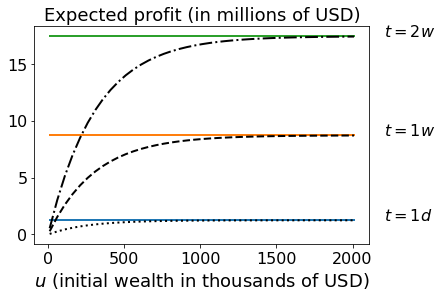

In [11]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
π_W = 0.1
p = 0.1
selector = (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
t_vec_ex = np.array([24, 24*7, 24*14]) 
time_horizon = np.array(['1d', '1w', '2w'])
for k in range(len(t_vec_ex)):
    c = p * π_W * W
    plt.plot(u_vec/1000, (ψ_V_df.EG[(selector) & (ψ_V_df.t == t_vec_ex[k])].values)/1000000, linewidth = 2)
    plt.plot(u_vec/1000, (ψ_V_df.V_u_T[(selector) & (ψ_V_df.t == t_vec_ex[k])].values -u_vec)/1000000, color = 'k',linewidth = 2, 
             linestyle = linestyles[k])
    plt.text(u_vec[-1]/1000 + 200, (- c * t_vec_ex[k] + p * λ * b * t_vec_ex[k]+50000)/1000000, '$t = '+time_horizon[k]+'$', fontsize = fontsize_ticker)
plt.xlabel('$u$ (initial wealth in thousands of USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)



### Depending on $\pi_W$

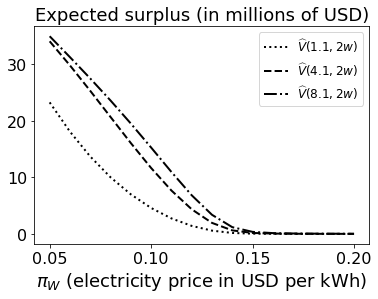

In [13]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
t = 24*14
p = 0.1
selector = (np.around(ψ_V_df.t.values, decimals = 0) == t) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
u_vec_ex = np.array([110000, 410000, 810000]) 
u_vec_names = np.array(['1.1', '4.1', '8.1'])

for k in range(len(u_vec_ex)):
    plt.plot(π_W_vec, ψ_V_df.V_u_T[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values/1000000,
             color = 'k', linestyle = linestyles[k], label = '$\widehat{V}('+u_vec_names[k]+', 2w)$', linewidth = 2)
plt.xlabel('$\pi_W$ (electricity price in USD per kWh)', fontsize = fontsize_axes)
plt.title('Expected surplus (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)

### Depending on $p$

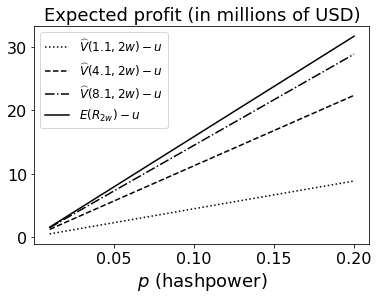

In [14]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
t = 24*14
π_W = 0.1
selector = (np.around(ψ_V_df.t.values, decimals = 0) == t) & (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W)
u_vec_ex = np.array([110000, 410000, 810000]) 
u_vec_names = np.array(['1.1', '4.1', '8.1'])

for k in range(len(u_vec_ex)):
    plt.plot(p_vec, (ψ_V_df.V_u_T[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values - u_vec_ex[k])/1000000,
             color = 'k', alpha = 1,linestyle = linestyles[k], label = '$\widehat{V}('+u_vec_names[k]+',2w)-u$')

plt.plot(p_vec, (ψ_V_df.EG[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values)/1000000,
             color = 'k', alpha = 1,linestyle = 'solid', label = '$E(R_{2w})-u$')
plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)